In [1]:
import os

import matplotlib.pyplot as plt
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import pymorphy2 as pm2
import seaborn as sns

### Data Loading

Загрузим датасет - корпус научных статей по физике:

In [2]:
data_directory = '../data/elibrary_physics'
file_contents = []

for filename in os.scandir(data_directory):
    if filename.is_file():
        with open(filename, "r", encoding='utf-8') as f:
            text = f.read()
            file_contents.append(text)

In [3]:
raw_df = pd.DataFrame(file_contents, columns=['raw_text'])
raw_df

,raw_text
0,1. Введение Физика элементарных частиц пережил...
1,Специфика нестационарного НПВО обсуждается в [...
2,"1. Введение Среды, в которых источники энергии..."
3,1. Введение Угол между направлением спина част...
4,В сентябрьском номере журнала Успехи физически...
...,...
995,ВВЕДЕНИЕ Для дистанционного исследования турбу...
996,ВВЕДЕНИЕ История мазеров на циклотронном резон...
997,ВВЕДЕНИЕ В последнее десятилетие значительное ...
998,ВВЕДЕНИЕ Исследование многих полупроводниковых...


In [4]:
print(f'Размер выборки: {raw_df.shape[0]}')

Размер выборки: 1000


### Data Preprocessing

Разобьем документы на токены. В качестве документов будем считать цельные предложения:

In [5]:
lemmatizer = pm2.MorphAnalyzer(lang='ru')

In [6]:
def lemmatize(lemmatizer, token):
    """Gets token's normalized form and part of speech."""
    normal_form = lemmatizer.parse(token)[0].normalized

    return normal_form.normal_form, normal_form.tag.POS

Разобьем весь корпус на отдельные предложения:

In [7]:
united_text = ' '.join(file_contents)

sentences = sent_tokenize(united_text, language='russian')
sentences_count = len(sentences)

In [8]:
print('Количество предложений:')
print('-'*23)
print(f'всего: {sentences_count}')
print(f'в среднем на статью: {sentences_count / raw_df.shape[0]}')

Количество предложений:
-----------------------
всего: 252830
в среднем на статью: 252.83


In [9]:
sentences[0], sentences[1], sentences[2], sentences[17], sentences[-1], 

('1.',
 'Введение Физика элементарных частиц пережила десятилетие поразительных экспериментальных достижений [1]: открытие t-кварка, наблюдение осцилляции солнечных и атмосферных нейтрино, измерение прямого СР-нару-шения в системе К-мезонов, а также СР-нарушения в системе В-мезонов, свидетельства ускоренного расширения Вселенной, определение доли темной энергии и темной материи во Вселенной и т.д. Эти результаты укрепили статус Стандартной модели (СМ) физики частиц как модели, успешно описывающей природу.',
 'Но они также показали, что плотность материи, входящей в СМ, составляет примерно 5% от плотности энергии Вселенной; поэтому необходимо рассматривать физику за пределами СМ, хотя прямое экспериментальное подтверждение ее существования все еще отсутствует.',
 'Почему потенциал хиггсовского бозона нестабилен в нуле?',
 '1   2   3   4   5   6   7')

Зададим список стоп-слов:

In [10]:
stop_words = stopwords.words('russian')

stop_words.extend(
    [
        'который', 'такой', 'этот', 'один', 'другой', 'каждый', 'некоторый',
        'тот', 'соответствующий', 'следующий', 'весь',
    ]
)

stop_words = set(stop_words)

*Следующий шаг **не нужно выполнять**, если леммы уже записаны в датафрейм.*

Сохраним о каждой лемме следующую информацию:
- часть речи (POS);
- частота встречаемости леммы (TF);
- подокументная частота леммы (DF).

In [11]:
lemmas_stats = {}

for document in sentences:
    # tokenization
    tokens = word_tokenize(document, language='russian')
    
    standardized_tokens = []
    for token in tokens:
        # case normalization
        if token.isalpha():
            token = token.lower()

        standardized_tokens.append(token)

    unique_tokens = set()
    for token in standardized_tokens:
        # normalization
        normal_form, pos = lemmatize(lemmatizer, token)
        
        # stop-words removal
        if normal_form in stop_words:
            continue
        
        unique_tokens.add(normal_form)

        # statistics update
        if normal_form not in lemmas_stats:
            lemmas_stats[normal_form] = {
                'POS': pos,
                'TF': 1,
                'DF': 0,
            }
        else:
            lemmas_stats[normal_form]['TF'] += 1

    for token in unique_tokens:
        lemmas_stats[token]['DF'] += 1

In [12]:
lemmas_stats['природа'], lemmas_stats['бозон'], lemmas_stats['результат']

({'POS': 'NOUN', 'TF': 398, 'DF': 392},
 {'POS': 'NOUN', 'TF': 191, 'DF': 161},
 {'POS': 'NOUN', 'TF': 5075, 'DF': 4853})

Запишем собранную информацию о леммах в датафрейм:

In [13]:
lemmas_df = pd.DataFrame(lemmas_stats).T.reset_index()
lemmas_df.rename(
    columns={
        'index': 'normal_form',
        'POS': 'part_of_speech',
        'TF': 'term_frequency',
        'DF': 'document_frequency',
    },
    inplace=True,
)

lemmas_df

,normal_form,part_of_speech,term_frequency,document_frequency
0,1,NaN,41574.0,27440.0
1,.,NaN,205173.0,204982.0
2,введение,NOUN,676,668
3,физика,NOUN,627,579
4,элементарный,ADJF,359,337
...,...,...,...,...
142593,ft_s,NaN,1.0,1.0
142594,"f_s=312,5",NaN,1.0,1.0
142595,=31,NaN,1.0,1.0
142596,"=3,87",NaN,1.0,1.0


Сохраним информацию о леммах в .csv файл, чтобы не пересчитывать их каждый раз:

In [14]:
lemmas_df.to_csv('../data/data_frames/lemmas_stats.csv')

*Всегда теперь будем **только подгружать** сгенерированный датафрейм.*

In [15]:
lemmas_df = pd.read_csv('../data/data_frames/lemmas_stats.csv', index_col=0)

Выделим для дальнейшего анализа 3 категории из общей выборки лемм:
1. существительные;
2. прилагательные (полные и краткие);
3. глаголы.

#### Nouns:

In [16]:
nouns_df = lemmas_df[lemmas_df['part_of_speech'] == 'NOUN']
nouns_df = nouns_df.reset_index(drop=True)

Выведем топ-50 существительных с **наибольшими** *tf-score* (слева) и *df-score* (справа):

In [17]:
max_tf_nouns_df = nouns_df.sort_values(by=['term_frequency'], ascending=False)
max_df_nouns_df = nouns_df.sort_values(by=['document_frequency'], ascending=False)

max_tf_nouns_df['<---------->'] = ''
pd.concat([max_tf_nouns_df.reset_index(drop=True), max_df_nouns_df.reset_index(drop=True)], axis=1).head(50)

,normal_form,part_of_speech,term_frequency,document_frequency,<---------->,normal_form,part_of_speech,term_frequency,document_frequency
0,значение,NOUN,6486.0,5800.0,,значение,NOUN,6486.0,5800.0
1,система,NOUN,5736.0,5046.0,,система,NOUN,5736.0,5046.0
2,уравнение,NOUN,5559.0,4546.0,,результат,NOUN,5075.0,4853.0
3,поле,NOUN,5147.0,4352.0,,случай,NOUN,4823.0,4612.0
4,результат,NOUN,5075.0,4853.0,,уравнение,NOUN,5559.0,4546.0
5,волна,NOUN,5009.0,4210.0,,поле,NOUN,5147.0,4352.0
6,случай,NOUN,4823.0,4612.0,,параметр,NOUN,4671.0,4311.0
7,область,NOUN,4728.0,4207.0,,работа,NOUN,4459.0,4232.0
8,параметр,NOUN,4671.0,4311.0,,волна,NOUN,5009.0,4210.0
9,функция,NOUN,4588.0,3892.0,,область,NOUN,4728.0,4207.0


Выведем топ-50 существительных с **наименьшими** *tf-score* (слева) и *df-score* (справа):

In [18]:
min_tf_nouns_df = nouns_df.sort_values(by=['term_frequency'], ascending=True)
min_df_nouns_df = nouns_df.sort_values(by=['document_frequency'], ascending=True)

min_tf_nouns_df['<---------->'] = ''
pd.concat([min_tf_nouns_df.reset_index(drop=True), min_df_nouns_df.reset_index(drop=True)], axis=1).head(50)

,normal_form,part_of_speech,term_frequency,document_frequency,<---------->,normal_form,part_of_speech,term_frequency,document_frequency
0,ofdm-приёмник,NOUN,1.0,1.0,,ofdm-приёмник,NOUN,1.0,1.0
1,коммутируемость,NOUN,1.0,1.0,,ли-ва-риация,NOUN,1.0,1.0
2,объемноцентриро,NOUN,1.0,1.0,,-модификация,NOUN,1.0,1.0
3,-ванна,NOUN,1.0,1.0,,нк-сплав,NOUN,1.0,1.0
4,харчев,NOUN,1.0,1.0,,доброхотов,NOUN,1.0,1.0
5,майя,NOUN,1.0,1.0,,рид,NOUN,1.0,1.0
6,ххх-моррт,NOUN,1.0,1.0,,чукбару,NOUN,1.0,1.0
7,гельфанд-цейтлин,NOUN,1.0,1.0,,маффин-тина,NOUN,1.0,1.0
8,фукция,NOUN,1.0,1.0,,1/1п,NOUN,1.0,1.0
9,xy-модель,NOUN,1.0,1.0,,га-мильтонов,NOUN,1.0,1.0


#### Adjectives:

In [19]:
adjectives_df = lemmas_df[lemmas_df['part_of_speech'].isin({'ADJF', 'ADJS'})]
adjectives_df = adjectives_df.reset_index(drop=True)

Выведем топ-50 прилагательных с **наибольшими** *tf-score* (слева) и *df-score* (справа):

In [20]:
max_tf_adjectives_df = adjectives_df.sort_values(by=['term_frequency'], ascending=False)
max_df_adjectives_df = adjectives_df.sort_values(by=['document_frequency'], ascending=False)

max_tf_adjectives_df['<---------->'] = ''
pd.concat([max_tf_adjectives_df.reset_index(drop=True), max_df_adjectives_df.reset_index(drop=True)], axis=1).head(50)

,normal_form,part_of_speech,term_frequency,document_frequency,<---------->,normal_form,part_of_speech,term_frequency,document_frequency
0,первый,ADJF,2468.0,2354.0,,первый,ADJF,2468.0,2354.0
1,различный,ADJF,2255.0,2157.0,,различный,ADJF,2255.0,2157.0
2,высокий,ADJF,2070.0,1963.0,,высокий,ADJF,2070.0,1963.0
3,малый,ADJF,1941.0,1867.0,,малый,ADJF,1941.0,1867.0
4,оптический,ADJF,1914.0,1727.0,,больший,ADJF,1902.0,1824.0
5,больший,ADJF,1902.0,1824.0,,оптический,ADJF,1914.0,1727.0
6,экспериментальный,ADJF,1736.0,1673.0,,экспериментальный,ADJF,1736.0,1673.0
7,магнитный,ADJF,1691.0,1451.0,,большой,ADJF,1667.0,1594.0
8,электронный,ADJF,1673.0,1545.0,,второй,ADJF,1664.0,1592.0
9,большой,ADJF,1667.0,1594.0,,равный,ADJF,1653.0,1575.0


Выведем топ-50 прилагательных с **наименьшими** *tf-score* (слева) и *df-score* (справа):

In [21]:
min_tf_adjectives_df = adjectives_df.sort_values(by=['term_frequency'], ascending=True)
min_df_adjectives_df = adjectives_df.sort_values(by=['document_frequency'], ascending=True)

min_tf_adjectives_df['<---------->'] = ''
pd.concat([min_tf_adjectives_df.reset_index(drop=True), min_df_adjectives_df.reset_index(drop=True)], axis=1).head(50)

,normal_form,part_of_speech,term_frequency,document_frequency,<---------->,normal_form,part_of_speech,term_frequency,document_frequency
0,направленно-диффузный,ADJF,1.0,1.0,,рентгено-флуоресцентный,ADJF,1.0,1.0
1,предупредительный,ADJF,1.0,1.0,,пропильный,ADJF,1.0,1.0
2,многовитковый,ADJF,1.0,1.0,,олигомерный,ADJF,1.0,1.0
3,магнитно-резонансный,ADJF,1.0,1.0,,ортофосфорный,ADJF,1.0,1.0
4,газоносный,ADJF,1.0,1.0,,паулик-паулик-эрдый,ADJF,1.0,1.0
5,4.особый,ADJF,1.0,1.0,,разовавшийся,ADJF,1.0,1.0
6,температурно-неоднородный,ADJF,1.0,1.0,,солянокислый,ADJF,1.0,1.0
7,извольный,ADJF,1.0,1.0,,комплексообразующий,ADJF,1.0,1.0
8,палочковидный,ADJF,1.0,1.0,,дифосфоновый,ADJF,1.0,1.0
9,пофазовый,ADJF,1.0,1.0,,тэтраэтоксисилан/трифункциональный,ADJF,1.0,1.0


#### Verbs:

In [22]:
verbs_df = lemmas_df[lemmas_df['part_of_speech'] == 'INFN']
verbs_df = verbs_df.reset_index(drop=True)

Выведем топ-50 глаголов с **наибольшими** *tf-score* (слева) и *df-score* (справа):

In [23]:
max_tf_verbs_df = verbs_df.sort_values(by=['term_frequency'], ascending=False)
max_df_verbs_df = verbs_df.sort_values(by=['document_frequency'], ascending=False)

max_tf_verbs_df['<---------->'] = ''
pd.concat([max_tf_verbs_df.reset_index(drop=True), max_df_verbs_df.reset_index(drop=True)], axis=1).head(50)

,normal_form,part_of_speech,term_frequency,document_frequency,<---------->,normal_form,part_of_speech,term_frequency,document_frequency
0,иметь,INFN,4632.0,4483.0,,иметь,INFN,4632.0,4483.0
1,получить,INFN,4570.0,4425.0,,получить,INFN,4570.0,4425.0
2,мочь,INFN,4440.0,4283.0,,мочь,INFN,4440.0,4283.0
3,являться,INFN,4113.0,4038.0,,являться,INFN,4113.0,4038.0
4,использовать,INFN,2692.0,2655.0,,использовать,INFN,2692.0,2655.0
5,показать,INFN,2591.0,2568.0,,показать,INFN,2591.0,2568.0
6,привести,INFN,2442.0,2422.0,,привести,INFN,2442.0,2422.0
7,соответствовать,INFN,2318.0,2243.0,,соответствовать,INFN,2318.0,2243.0
8,приводить,INFN,2060.0,2037.0,,приводить,INFN,2060.0,2037.0
9,составлять,INFN,1990.0,1902.0,,составлять,INFN,1990.0,1902.0


Выведем топ-50 глаголов с **наименьшими** *tf-score* (слева) и *df-score* (справа):

In [24]:
min_tf_verbs_df = verbs_df.sort_values(by=['term_frequency'], ascending=True)
min_df_verbs_df = verbs_df.sort_values(by=['document_frequency'], ascending=True)

min_tf_verbs_df['<---------->'] = ''
pd.concat([min_tf_verbs_df.reset_index(drop=True), min_df_verbs_df.reset_index(drop=True)], axis=1).head(50)

,normal_form,part_of_speech,term_frequency,document_frequency,<---------->,normal_form,part_of_speech,term_frequency,document_frequency
0,пережить,INFN,1.0,1.0,,пережить,INFN,1.0,1.0
1,заселиться,INFN,1.0,1.0,,4.передать,INFN,1.0,1.0
2,фотосенсибилизировать,INFN,1.0,1.0,,7.повторять,INFN,1.0,1.0
3,нарабатывать,INFN,1.0,1.0,,дописать,INFN,1.0,1.0
4,четыреххнуть,INFN,1.0,1.0,,cu-обеднить,INFN,1.0,1.0
5,дефаззифицировать,INFN,1.0,1.0,,2.присвоить,INFN,1.0,1.0
6,дефаззифицироваться,INFN,1.0,1.0,,финансироваться,INFN,1.0,1.0
7,сu-обогатить,INFN,1.0,1.0,,трехгорбовать,INFN,1.0,1.0
8,cu-обеднить,INFN,1.0,1.0,,дефаззифицировать,INFN,1.0,1.0
9,yjбыть,INFN,1.0,1.0,,истощать,INFN,1.0,1.0


#### Visual comparison

Оценим, насколько различаются показатели по tf и df в топ-50 между различными частями речи:

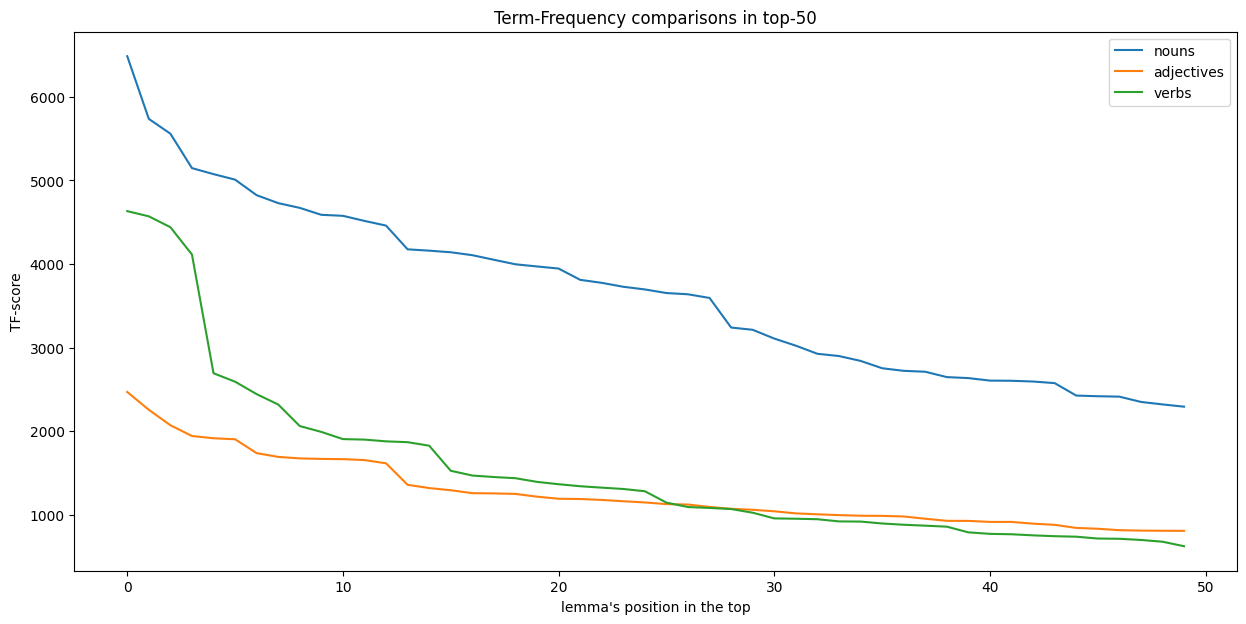

In [25]:
fig1 = plt.figure(figsize=(15, 7))

ax1 = fig1.add_subplot(111)
ax1.set_title('Term-Frequency comparisons in top-50')
ax1.set_xlabel("lemma's position in the top")
ax1.set_ylabel('TF-score')

ax1.plot(max_tf_nouns_df.reset_index(drop=True)['term_frequency'].head(50), label='nouns')
ax1.plot(max_tf_adjectives_df.reset_index(drop=True)['term_frequency'].head(50), label='adjectives')
ax1.plot(max_tf_verbs_df.reset_index(drop=True)['term_frequency'].head(50), label='verbs')

plt.legend()

plt.show()

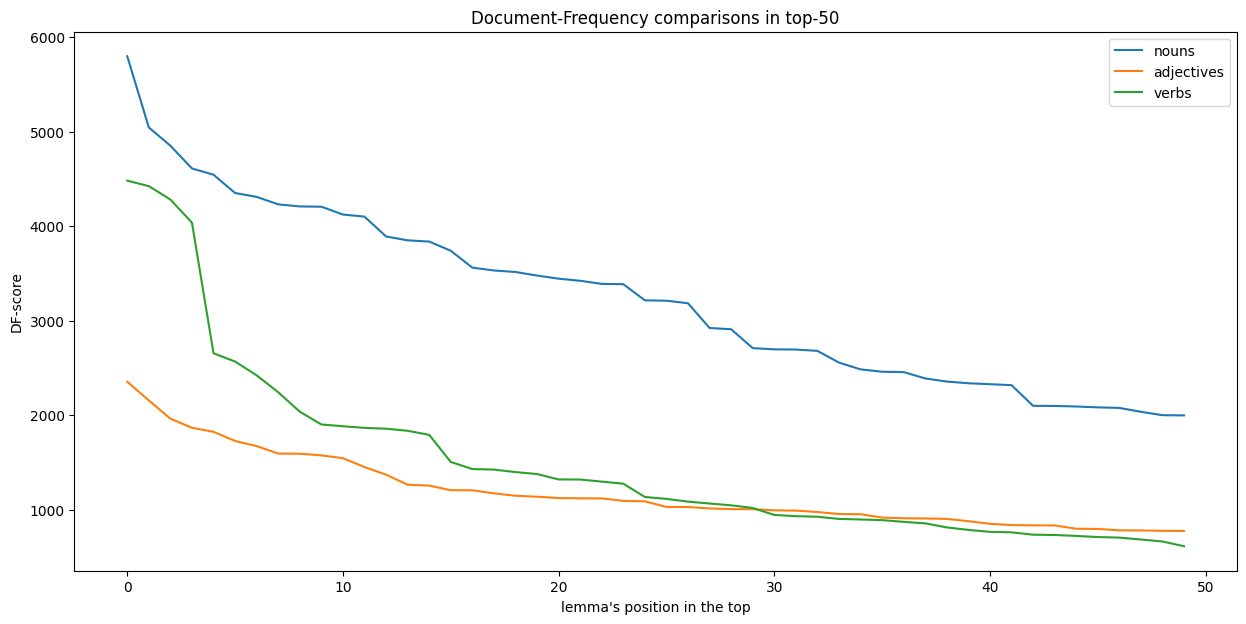

In [26]:
fig2 = plt.figure(figsize=(15, 7))

ax2 = fig2.add_subplot(111)
ax2.set_title('Document-Frequency comparisons in top-50')
ax2.set_xlabel("lemma's position in the top")
ax2.set_ylabel('DF-score')

ax2.plot(max_df_nouns_df.reset_index(drop=True)['document_frequency'].head(50), label='nouns')
ax2.plot(max_df_adjectives_df.reset_index(drop=True)['document_frequency'].head(50), label='adjectives')
ax2.plot(max_df_verbs_df.reset_index(drop=True)['document_frequency'].head(50), label='verbs')

plt.legend()

plt.show()

Отметим следующие моменты:
1. уже в топ-50 можно наблюдать в действии закон Ципфа - первые 5-10 лемм встречаются очень часто, все последующие все реже и реже (экспоненциально);
2. существительные в среднем в 2-3 раза частотнее прилагательных и глаголов, последние между собой отличаются не сильно после топ-25 лемм (по df даже меньше, чем по tf);
3. разница между графиками по tf и df достаточно незначительна.

#### Unclassified words

Посмотрим, какие леммы анализатор pymorphy2 не смог отнести ни к одной части речи:

In [27]:
nan_df = lemmas_df[lemmas_df['part_of_speech'].isna()]
nan_df = nan_df.reset_index(drop=True)

nan_df

,normal_form,part_of_speech,term_frequency,document_frequency
0,1,NaN,41574.0,27440.0
1,.,NaN,205173.0,204982.0
2,[,NaN,24590.0,18615.0
3,],NaN,41870.0,26895.0
4,:,NaN,13636.0,12100.0
...,...,...,...,...
104414,ft_s,NaN,1.0,1.0
104415,"f_s=312,5",NaN,1.0,1.0
104416,=31,NaN,1.0,1.0
104417,"=3,87",NaN,1.0,1.0


Выведем топ-50 нераспознанных слов с **наибольшими** *tf-score* (слева) и *df-score* (справа):

In [28]:
max_tf_nan_df = nan_df.sort_values(by=['term_frequency'], ascending=False)
max_df_nan_df = nan_df.sort_values(by=['document_frequency'], ascending=False)

max_tf_nan_df['<---------->'] = ''
pd.concat([max_tf_nan_df.reset_index(drop=True), max_df_nan_df.reset_index(drop=True)], axis=1).head(50)

,normal_form,part_of_speech,term_frequency,document_frequency,<---------->,normal_form,part_of_speech,term_frequency,document_frequency
0,",",NaN,290468.0,130658.0,,.,NaN,205173.0,204982.0
1,.,NaN,205173.0,204982.0,,",",NaN,290468.0,130658.0
2,),NaN,173657.0,77775.0,,),NaN,173657.0,77775.0
3,(,NaN,170693.0,77354.0,,(,NaN,170693.0,77354.0
4,the,NaN,161923.0,62121.0,,the,NaN,161923.0,62121.0
5,of,NaN,70190.0,44453.0,,?,NaN,60526.0,51031.0
6,=,NaN,62362.0,32872.0,,of,NaN,70190.0,44453.0
7,?,NaN,60526.0,51031.0,,a,NaN,52463.0,36474.0
8,a,NaN,52463.0,36474.0,,and,NaN,45662.0,33648.0
9,and,NaN,45662.0,33648.0,,in,NaN,43796.0,33303.0


Выведем топ-50 нераспознанных слов с **наименьшими** *tf-score* (слева) и *df-score* (справа):

In [29]:
min_tf_nan_df = nan_df.sort_values(by=['term_frequency'], ascending=True)
min_df_nan_df = nan_df.sort_values(by=['document_frequency'], ascending=True)

min_tf_nan_df['<---------->'] = ''
pd.concat([min_tf_nan_df.reset_index(drop=True), min_df_nan_df.reset_index(drop=True)], axis=1).head(50)

,normal_form,part_of_speech,term_frequency,document_frequency,<---------->,normal_form,part_of_speech,term_frequency,document_frequency
0,\ni,NaN,1.0,1.0,,\ni,NaN,1.0,1.0
1,a1-1.5,NaN,1.0,1.0,,и/ч,NaN,1.0,1.0
2,длина:3571,NaN,1.0,1.0,,nkrt,NaN,1.0,1.0
3,uшд:100,NaN,1.0,1.0,,yk/,NaN,1.0,1.0
4,y:400,NaN,1.0,1.0,,компонента17,NaN,1.0,1.0
5,1.857,NaN,1.0,1.0,,jlt0,NaN,1.0,1.0
6,3.4-3.5,NaN,1.0,1.0,,_t-lf,NaN,1.0,1.0
7,16.59,NaN,1.0,1.0,,атк,NaN,1.0,1.0
8,2865,NaN,1.0,1.0,,л05,NaN,1.0,1.0
9,8.750,NaN,1.0,1.0,,л0м,NaN,1.0,1.0


Визуализируем влияние неклассифицированных слов:

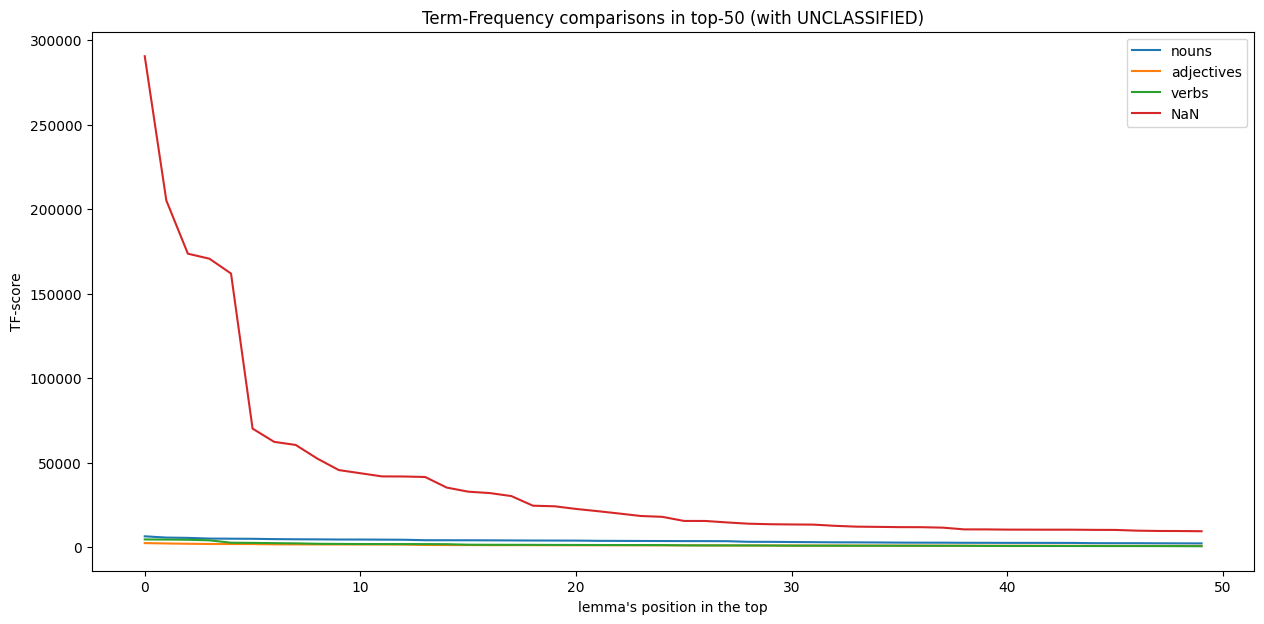

In [30]:
fig3 = plt.figure(figsize=(15, 7))

ax3 = fig3.add_subplot(111)
ax3.set_title('Term-Frequency comparisons in top-50 (with UNCLASSIFIED)')
ax3.set_xlabel("lemma's position in the top")
ax3.set_ylabel('TF-score')

ax3.plot(max_tf_nouns_df.reset_index(drop=True)['term_frequency'].head(50), label='nouns')
ax3.plot(max_tf_adjectives_df.reset_index(drop=True)['term_frequency'].head(50), label='adjectives')
ax3.plot(max_tf_verbs_df.reset_index(drop=True)['term_frequency'].head(50), label='verbs')
ax3.plot(max_tf_nan_df.reset_index(drop=True)['term_frequency'].head(50), label='NaN')

plt.legend()

plt.show()

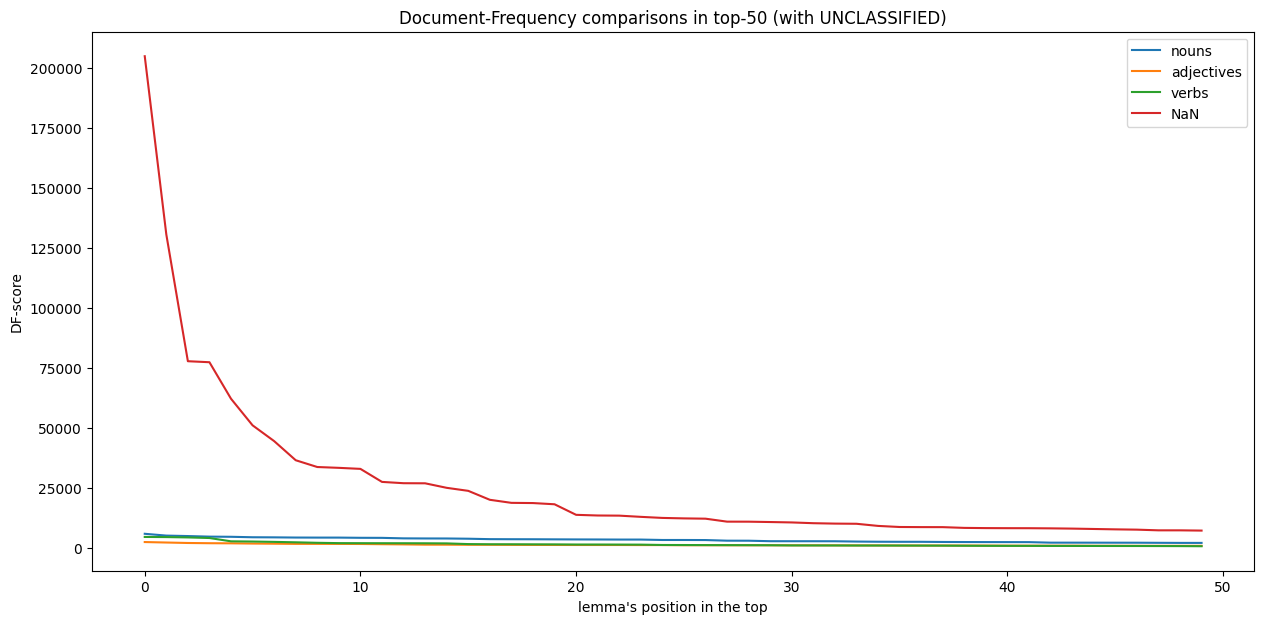

In [31]:
fig4 = plt.figure(figsize=(15, 7))

ax4 = fig4.add_subplot(111)
ax4.set_title('Document-Frequency comparisons in top-50 (with UNCLASSIFIED)')
ax4.set_xlabel("lemma's position in the top")
ax4.set_ylabel('DF-score')

ax4.plot(max_df_nouns_df.reset_index(drop=True)['document_frequency'].head(50), label='nouns')
ax4.plot(max_df_adjectives_df.reset_index(drop=True)['document_frequency'].head(50), label='adjectives')
ax4.plot(max_df_verbs_df.reset_index(drop=True)['document_frequency'].head(50), label='verbs')
ax4.plot(max_df_nan_df.reset_index(drop=True)['document_frequency'].head(50), label='NaN')

plt.legend()

plt.show()

**P.S.:** Хьюстон, у нас проблемы :)

#### Notes

- качество лемматизации (в плохом смысле) лучше отображается на **наименее популярных словах** (tf=df=1);
- нераспознанные слова с большим tf/df - английские стоп-слова и отдельные спец-символы, слова же с маленьким tf/idf - формулы и числа, которые могут быть релевантными;
- имена ученых, исследователей, и т.д. лемматизатор выделяет в существительные и прилагательные -> в идеале под них **нужна своя отдельная категория**;
- если пробела между словами нет, то они **будут вместе считаться единым словом** - и потеря информации, и зашумление выборки;
- **очень много мусора**, который встроенный анализатор pymorphy2 не способен обнаружить:
    - однобуквенные слова;
    - формулы по типу "=<число>";
    - всевозможные вариации <начало слова>/<конец слова>, "/" не единственный кульприт подобного. Подобный шум может даже приводить к неправильной классификации леммы -> например, "вещественнознач-ной" анализатор считает существительным.
- **шумы составляют большую часть выборки** -> ~105k/144k (73%) лемм (надо подумать, как похитрее чистить данные).
- анализатор **чаще всего путает** прилагательные -> с местоимениями, числительными, причастиями.

#### Improvements

Более серьезная чистка словаря лемм позволит не только сократить кол-во ошибочных случаев, но и уменьшить размер выборки (быстрее обучаться будем). Что можно сделать:
- задействовать **регулярки** для удаления спец. символов, но важно понимать структуру данных, чтобы не отсечь лишнего -> вручную просмотреть все статьи не вариант, как быть тогда? Удалять только распространенные паттерны по типу ссылок всяких "https://...//.."?
- вручную найти **явно ошибочные группы слов** (например, имена людей) и выделить им отдельную группу (но это выглядит очень трудозатратным процессом, т.к. таких ошибочных групп может быть несколько);
- удалить все **нераспознанные анализатором слова**. По большей части, числа и спец. смиволы, есть и английские слова. Есть идея завести второй независимый анализатор уже по английскому языку, и прогнать его через такие слова. Таким образом, удастся сохранить слова на английском/латыни, но формулы выкинуть. Это **позволит в идеале раза в 3 сократить размер словаря** лемм. *Вопрос*: а можно ли так смело выкинуть формулы? Суммаризации статей википедии обычно текстовые, но у нас специфическая тематика, что добавляет проблем. 